# 0) Setups

In [5]:
# import libraries
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()

In [6]:
# reading data inside xml file to a variable under the name data
with open(os.path.join(os.getenv("RESOURCES"), "Uniklinikum_Freiburg_map.osm"), 'r', encoding='utf-8') as f:
    data = f.read()
 
# passing stored data inside beautifulsoup parser, storing the returned object 
bs_data = BeautifulSoup(data, "xml")

# 1) Nodes

In [7]:
# store all nodes in a dictionary and give them a label
nds = {}
for node in bs_data.select('node'):
    # first case: store has a name
    if node.find('tag', k='name'):
        # map node id to a tuple of (lat, lon, name)
        nds[node['id']] = (node['lon'], node['lat'], node.find('tag', k='name').get('v'))
    else:
        nds[node['id']] = (node['lon'], node['lat'], None)

# print the number of total nodes      
print('The map includes {} total nodes.'.format(len(nds.keys())))

The map includes 1790 total nodes.


In [8]:
# print the first node
print('The first node is: {}'.format(nds[list(nds.keys())[0]]))

The first node is: ('7.8372915', '48.0095474', None)


In [9]:
# create dictionary of all nodes that have a name and map id to name
named_nodes = {k: v[2] for k, v in nds.items() if v[2]}

In [10]:
list(named_nodes.values())

['Emmaus Kapelle',
 'Neurozentrum [1]',
 'Augenklinik / HNO',
 'Neurozentrum [2]',
 'Café am Eck',
 'Bistro am Lorenzring',
 'Kiosk Frauenklinik',
 'Stimme vom Berg',
 'Klinik für Frauenheilkunde [1]',
 'Klinik für Frauenheilkunde [2]',
 'Sympathy',
 'Zwischen den Räumen',
 'Terrakotta',
 'Freischwimmer',
 'Notaufnahme',
 'Tripylon',
 'Hermann Nothnagel',
 'Paracelsus',
 'Herman Boerhaave',
 'Johann Lukas Schönlein',
 'Hippokrates von Kos',
 'Theodor Billroth',
 'Ernst von Bergmann',
 'Joseph Lister',
 'Ambroise Paré',
 'Guy de Chauliac',
 'Adolf Lorenz',
 'Creativ Coiffeur Löffler']

# 2) Ways

In [11]:
# store all ways in a dictionary and give them a label according to their highway type
ways = {}
for way in bs_data.select('way'):
    # filter out ways that don't have a highway tag
    if way.find('tag', k='highway'):
        # map way id to a tuple of (list of node ids, highway type)
        ways[way['id']] = ([nd['ref'] for nd in way.find_all('nd')],
                           way.find('tag', k='highway').get('v'))
    else:
        ways[way['id']] = ([nd['ref'] for nd in way.find_all('nd')],
                           None)

In [12]:
# list with all possible values of the key 'highway'
highways = list(set([way[1] for way in ways.values() if way[1] is not None]))
# print the different highway types
print('The different highway types are: {}'.format(highways))

The different highway types are: ['steps', 'service', 'construction', 'pedestrian', 'unclassified', 'path', 'footway', 'cycleway']


# 3) Footprints of buildings

In [13]:
# store all foorprints in a dictionary
footprints = {}
for way in bs_data.select('way'):
    # filter out ways that don't have a building tag
    if way.find('tag', k='building'):
        footprints[way['id']] = [nd['ref'] for nd in way.find_all('nd')]

# print the number of footprints
print('The map includes {} footprints in total.'.format(len(footprints.keys())))

The map includes 40 footprints in total.


# 4) Relations

In [14]:
# print the names of all relations
relations = []
for relation in bs_data.select('relation'):
    if relation.find('tag', k='name'):
        relations.append(relation.find('tag', k='name').get('v'))
print('The names of the relations are: {}'.format(relations))

The names of the relations are: ['Universitäts-Notfallzentrum (UNZ)', 'Universitätsklinikum Freiburg', 'Neurozentrum', 'Schnittbildzentrum', 'Chirurgische Klinik', 'Neue Kinderklinik']


# 5) Graph

In [63]:
# define necesssary parameters for the graph
params = {
    'named_nodes': ['Zwischen den Räumen', 'Stimme vom Berg',
                    'Emmaus Kapelle', 'Klinik für Frauenheilkunde [1]'],
                    #'Ernst von Bergmann'], # default: named_nodes.values()
    'highways': ['footway', 'service'], # default: highways
    'footprints': False # default: True
}

In [87]:
# params = {
#     'named_nodes':['Emmaus Kapelle', 'Neurozentrum [1]', 'Augenklinik / HNO',
#                     'Neurozentrum [2]', 'Café am Eck', 'Bistro am Lorenzring',
#                     'Stimme vom Berg', 'Klinik für Frauenheilkunde [1]',
#                     'Klinik für Frauenheilkunde [2]', 'Zwischen den Räumen',
#                     'Terrakotta', 'Herman Boerhaave', 'Ernst von Bergmann'], # default: named_nodes.values()
#     'highways': highways, # default: highways
#     'footprints': True # default: True
# }

# params = {
#     'named_nodes': named_nodes.values(),
#     'highways': highways,
#     'footprints': False
# }

In [65]:
# create a graph for the different types of highways
G_highways = nx.Graph()

if params['highways'] is not None:
    for way_id, (nodes, highway_type) in ways.items():
        # filter out ways that don't have a highway tag
        if highway_type in params['highways']:
            G_highways.add_edges_from(zip(nodes[:-1], nodes[1:]))

In [66]:
# create a dictionary that maps every created edge to its highway type
edge_labels_highways = {}
# iterate over all edges that are highways
for u, v in G_highways.edges():
    # iterate over all ways
    for way_id, (nodes, highway_type) in ways.items():
        # check if the edge is in a way and add the highway type to the dictionary
        if u in nodes and v in nodes:
            edge_labels_highways[(u, v)] = highway_type

In [67]:
# save the edge labels in a csv file
df = pd.DataFrame.from_dict(edge_labels_highways, orient='index')
df.to_csv('edge_labels_highways.csv')

In [68]:
# create graph with footprints
G_footprints = nx.Graph()
if params['footprints']:
    # iterate over all footprints and add them to the graph
    for footprint_id, nodes in footprints.items():
        G_footprints.add_edges_from(zip(nodes[:-1], nodes[1:]))

In [69]:
# combine the single graphs for the plot
G = nx.Graph()
# add nodes and edges from the two graphs to the combined graph
G.add_nodes_from(G_highways.nodes)
G.add_nodes_from(G_footprints.nodes)
G.add_edges_from(G_highways.edges)
G.add_edges_from(G_footprints.edges)

In [70]:
# # add further nodes that have a name as key attribute but are not part of any way
# if params['named_nodes'] is not None:
#     for node_id, name in [item for item in named_nodes.items() if item[1] in params['named_nodes']]:
#         if node_id not in G.nodes:
#             G.add_node(node_id, name=name)

In [71]:
# create dictionary that maps every named node to the closest node on a way
closest_node = {}
# iterate over all named nodes in the parameter list params['named_nodes]
for node_id, name in [item for item in named_nodes.items() if item[1] in params['named_nodes']]:
    # initialize minimum distance to infinity
    min_dist = float('inf')
    # iterate over all ways with an allowed highway type
    for way_id, way in ways.items():
        if way[1] in params['highways']:
            # iterate over all nodes in the way
            for nd_id in way[0]:
                # calculate distance
                dist = (float(nds[nd_id][0]) - float(nds[node_id][0]))**2 + (float(nds[nd_id][1]) - float(nds[node_id][1]))**2
                # if distance is smaller than minimum distance, update minimum distance and closest node
                if dist < min_dist:
                    min_dist = dist
                    closest_node[node_id] = nd_id

# add edges from named nodes to the closest node on a way if the nodes are not the same
for node_id, nd_id in closest_node.items():
    if node_id != nd_id:
        G.add_edge(node_id, nd_id)

In [72]:
# analyze size of the final graph
print('The graph has {} nodes and {} edges.'.format(G.number_of_nodes(), G.number_of_edges()))

The graph has 221 nodes and 229 edges.


# 6) Plot

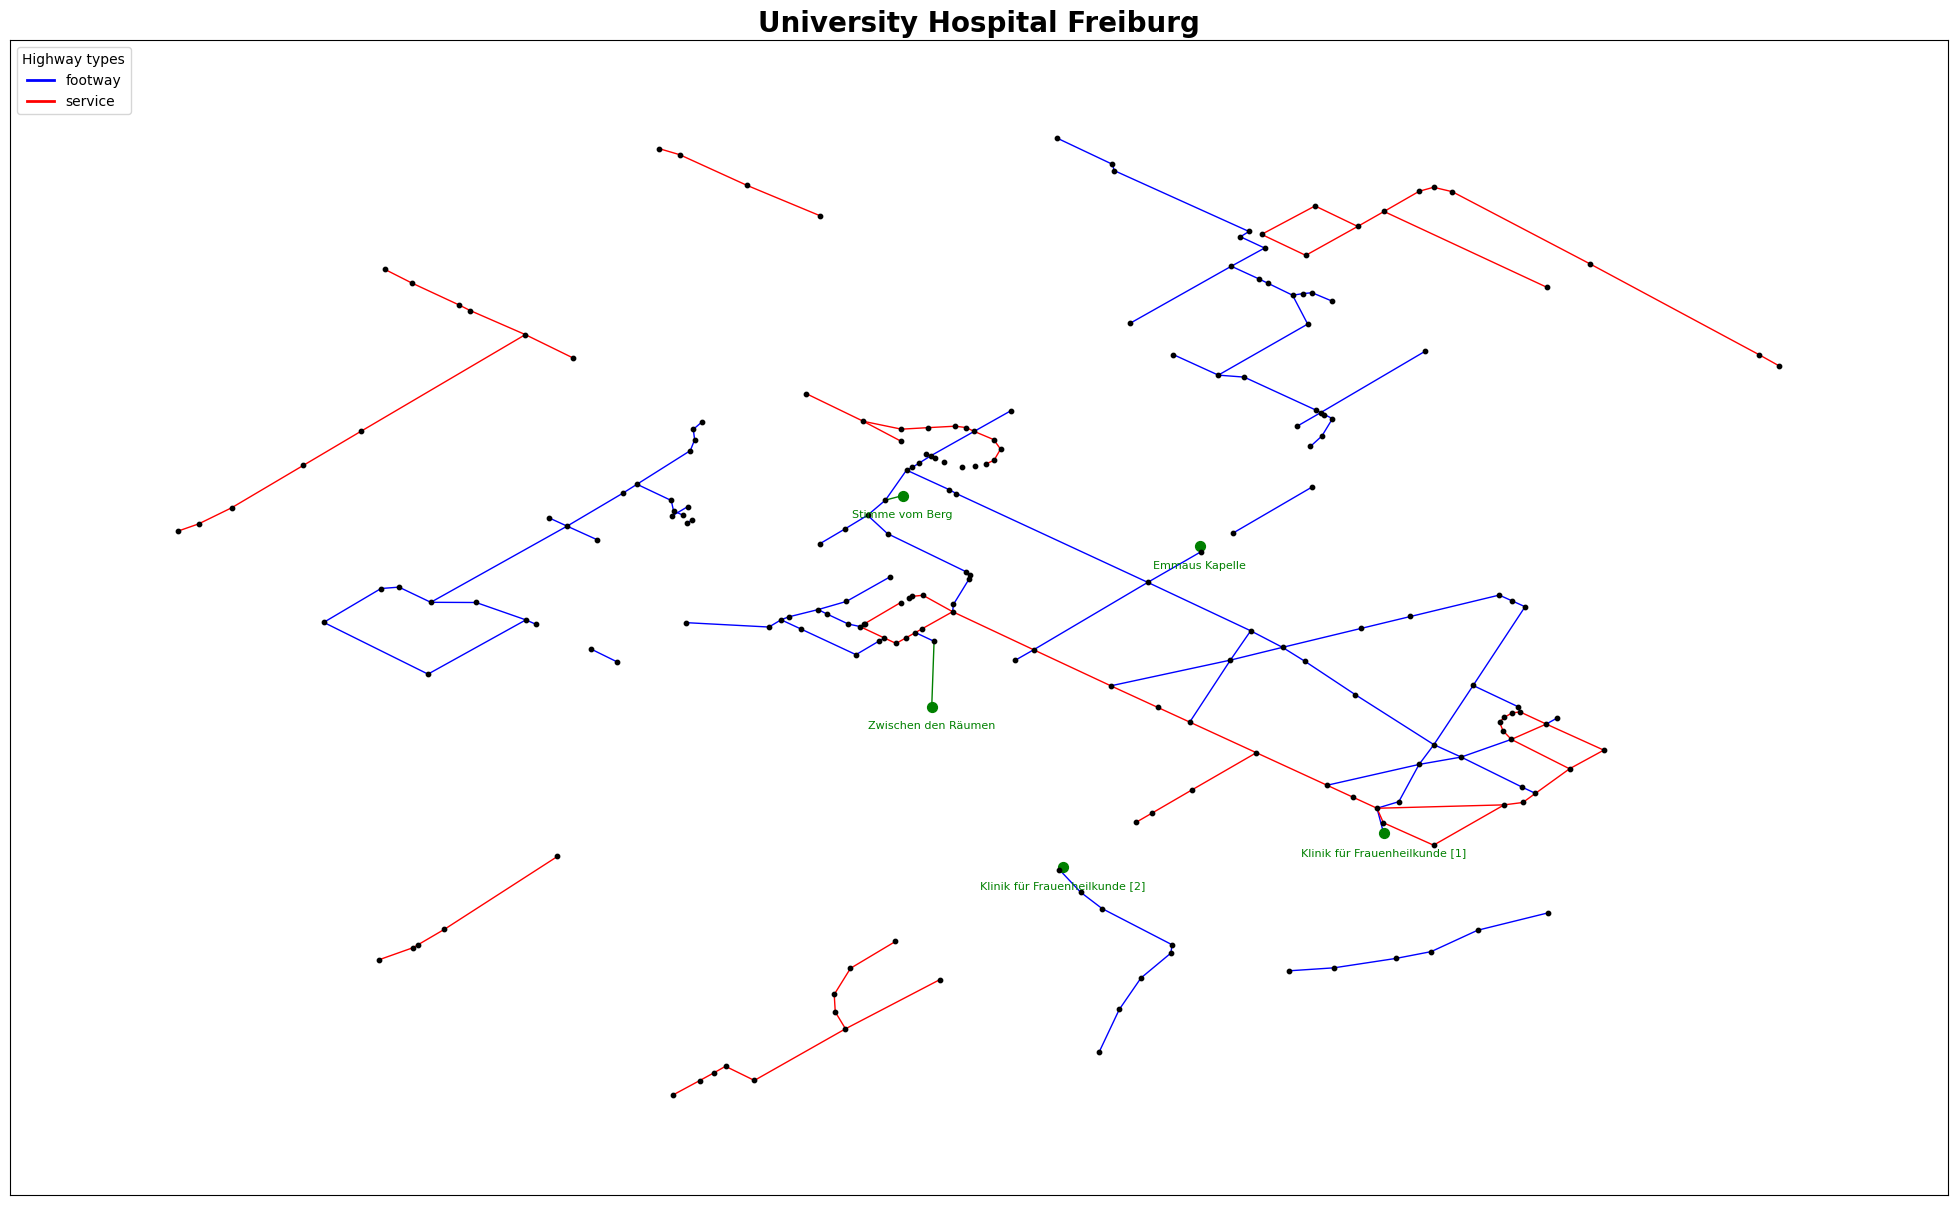

In [73]:
# define colors for the different highway types
colors = ['blue', 'red', 'yellow', 'orange', 'green', 'purple', 'pink', 'brown']

# plot the graph where all nodes are placed at their geographical position
pos = {key: (float(value[0]), float(value[1])) for key, value in nds.items()}
# correct position for the labels
pos_labels = {key: (float(value[0]), float(value[1]) - 0.00008) for key, value in nds.items()}
plt.figure(figsize=(25, 15))

# plot only nodes that have a name
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes if nds[node][2] is not None and node in named_nodes],
                       node_color='green', node_size=50)
# label them and set position above node
nx.draw_networkx_labels(G, pos = pos_labels,
                        labels={node: nds[node][2] for node in G.nodes if nds[node][2] is not None and node in named_nodes},
                        font_size=8, font_color='green')
# add all other nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes if nds[node][2] is None],
                       node_color='black', node_size=10)
# add edges from the footprints graph
nx.draw_networkx_edges(G, pos, edgelist=G_footprints.edges, edge_color='black', width=0.5)
# add edges from the highways graph
if params['highways'] is not None:
    for i, highway_type in enumerate(params['highways']):
        nx.draw_networkx_edges(G, pos, edgelist=[edge for edge in G_highways.edges if edge_labels_highways[edge] == highway_type],
                            edge_color=colors[i], width=1)
# add edges from named nodes to the closest node on a way
nx.draw_networkx_edges(G, pos, edgelist=[(node, closest_node[node]) for node in closest_node],
                       edge_color='green', width=1)
# plot the graph
plt.title('University Hospital Freiburg', fontsize=20, fontweight='bold')
# legend that described colors and highway types
if params['highways'] is not None:
    plt.legend([plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(params['highways']))],
            params['highways'], fontsize=10, title='Highway types', loc='upper left')
plt.show()

# 7) Subgraph

In [74]:
# split graph into connected components
connected_components = list(nx.connected_components(G))
# print the number of connected components
print('The graph has {} connected components.'.format(len(connected_components)))

The graph has 12 connected components.


In [75]:
# create a subgraph of the largest connected component
G_largest = G.subgraph(connected_components[0])

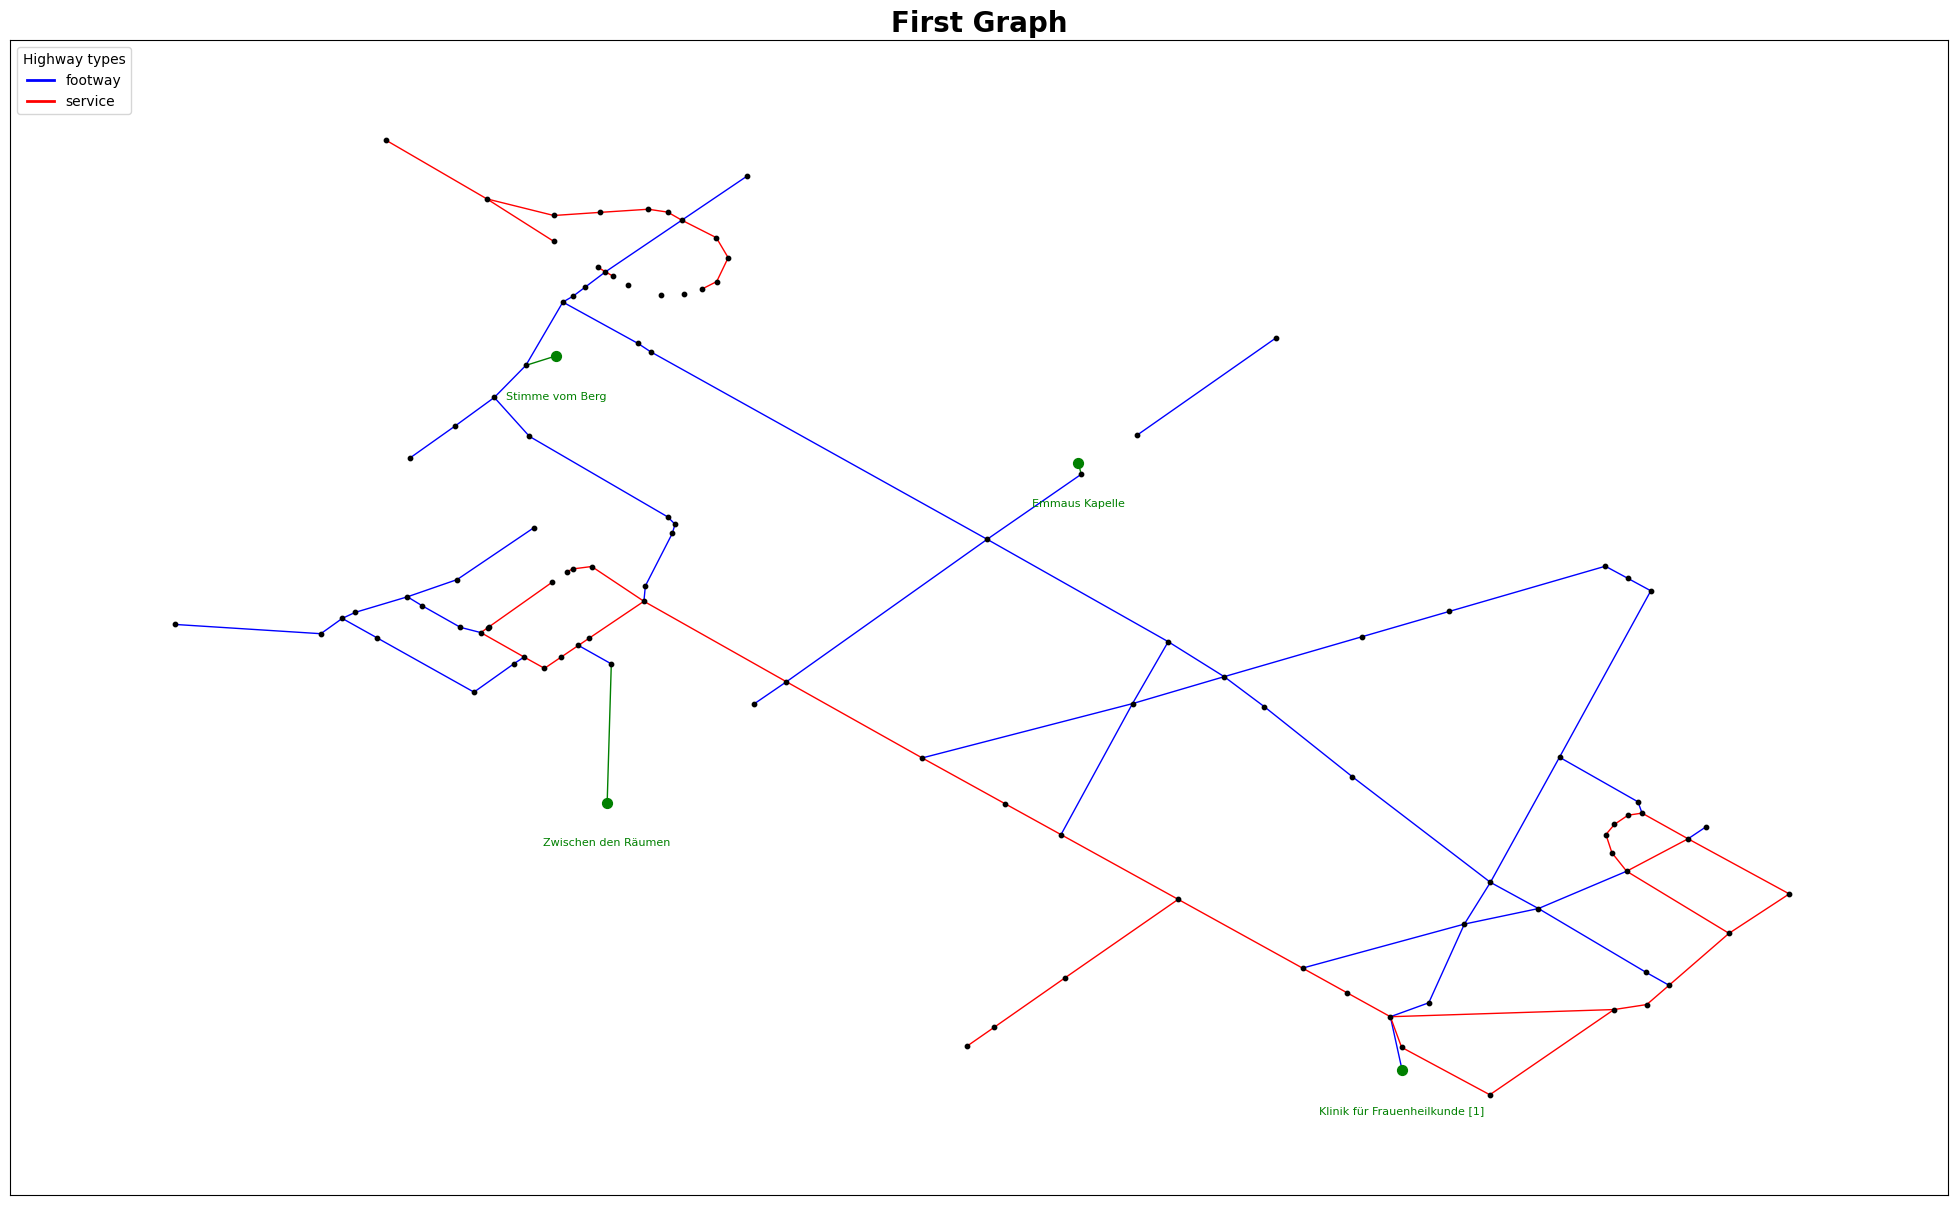

In [76]:
# define colors for the different highway types
colors = ['blue', 'red', 'yellow', 'orange', 'green', 'purple', 'pink', 'brown']

# plot the graph where all nodes are placed at their geographical position
pos = {key: (float(value[0]), float(value[1])) for key, value in nds.items()}
# correct position for the labels
pos_labels = {key: (float(value[0]), float(value[1]) - 0.00008) for key, value in nds.items()}
plt.figure(figsize=(25, 15))

# plot subgraph of the largest connected component
# plot only nodes that have a name
nx.draw_networkx_nodes(G_largest, pos, nodelist=[node for node in G_largest.nodes if nds[node][2] is not None and node in named_nodes],
                       node_color='green', node_size=50)
# label them
nx.draw_networkx_labels(G_largest, pos=pos_labels, labels={node: nds[node][2] for node in G_largest.nodes if nds[node][2] is not None and node in named_nodes},
                        font_size=8, font_color='green')
# add all other nodes that are part of the largest connected component
nx.draw_networkx_nodes(G_largest, pos, nodelist=[node for node in G_largest.nodes if nds[node][2] is None],
                       node_color='black', node_size=10)
# add edges from the highways graph if they are part of the largest connected component
if params['highways'] is not None:
    for i, highway_type in enumerate(params['highways']):
        nx.draw_networkx_edges(G_largest, pos, edgelist=[edge for edge in G_highways.edges
                                                         if edge_labels_highways[edge] == highway_type
                                                         and edge[0] in G_largest.nodes and edge[1] in G_largest.nodes],
                            edge_color=colors[i], width=1)
# add edges from named nodes to the closest node on a way
nx.draw_networkx_edges(G_largest, pos, edgelist=[(node, closest_node[node]) for node in closest_node],
                       edge_color='green', width=1)

# plot the graph
plt.title('First Graph', fontsize=20, fontweight='bold')
# legend that described colors and highway types
if params['highways'] is not None:
    plt.legend([plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(params['highways']))],
            params['highways'], fontsize=10, title='Highway types', loc='upper left')
plt.show()

# 8) Weighted Graphs

In [77]:
# add weights to the edges of the subgraph G_largest
G_largest_weighted = nx.Graph()
G_largest_weighted.add_nodes_from(G_largest.nodes)
G_largest_weighted.add_edges_from(G_largest.edges)
# add edges from named nodes to the closest node on a way
G_largest_weighted.add_edges_from([(node, closest_node[node]) for node in closest_node])
# add weights to the edges
for u, v in G_largest_weighted.edges():
    G_largest_weighted[u][v]['weight'] = ((float(nds[u][0]) - float(nds[v][0]))**2 + (float(nds[u][1]) - float(nds[v][1]))**2)**0.5

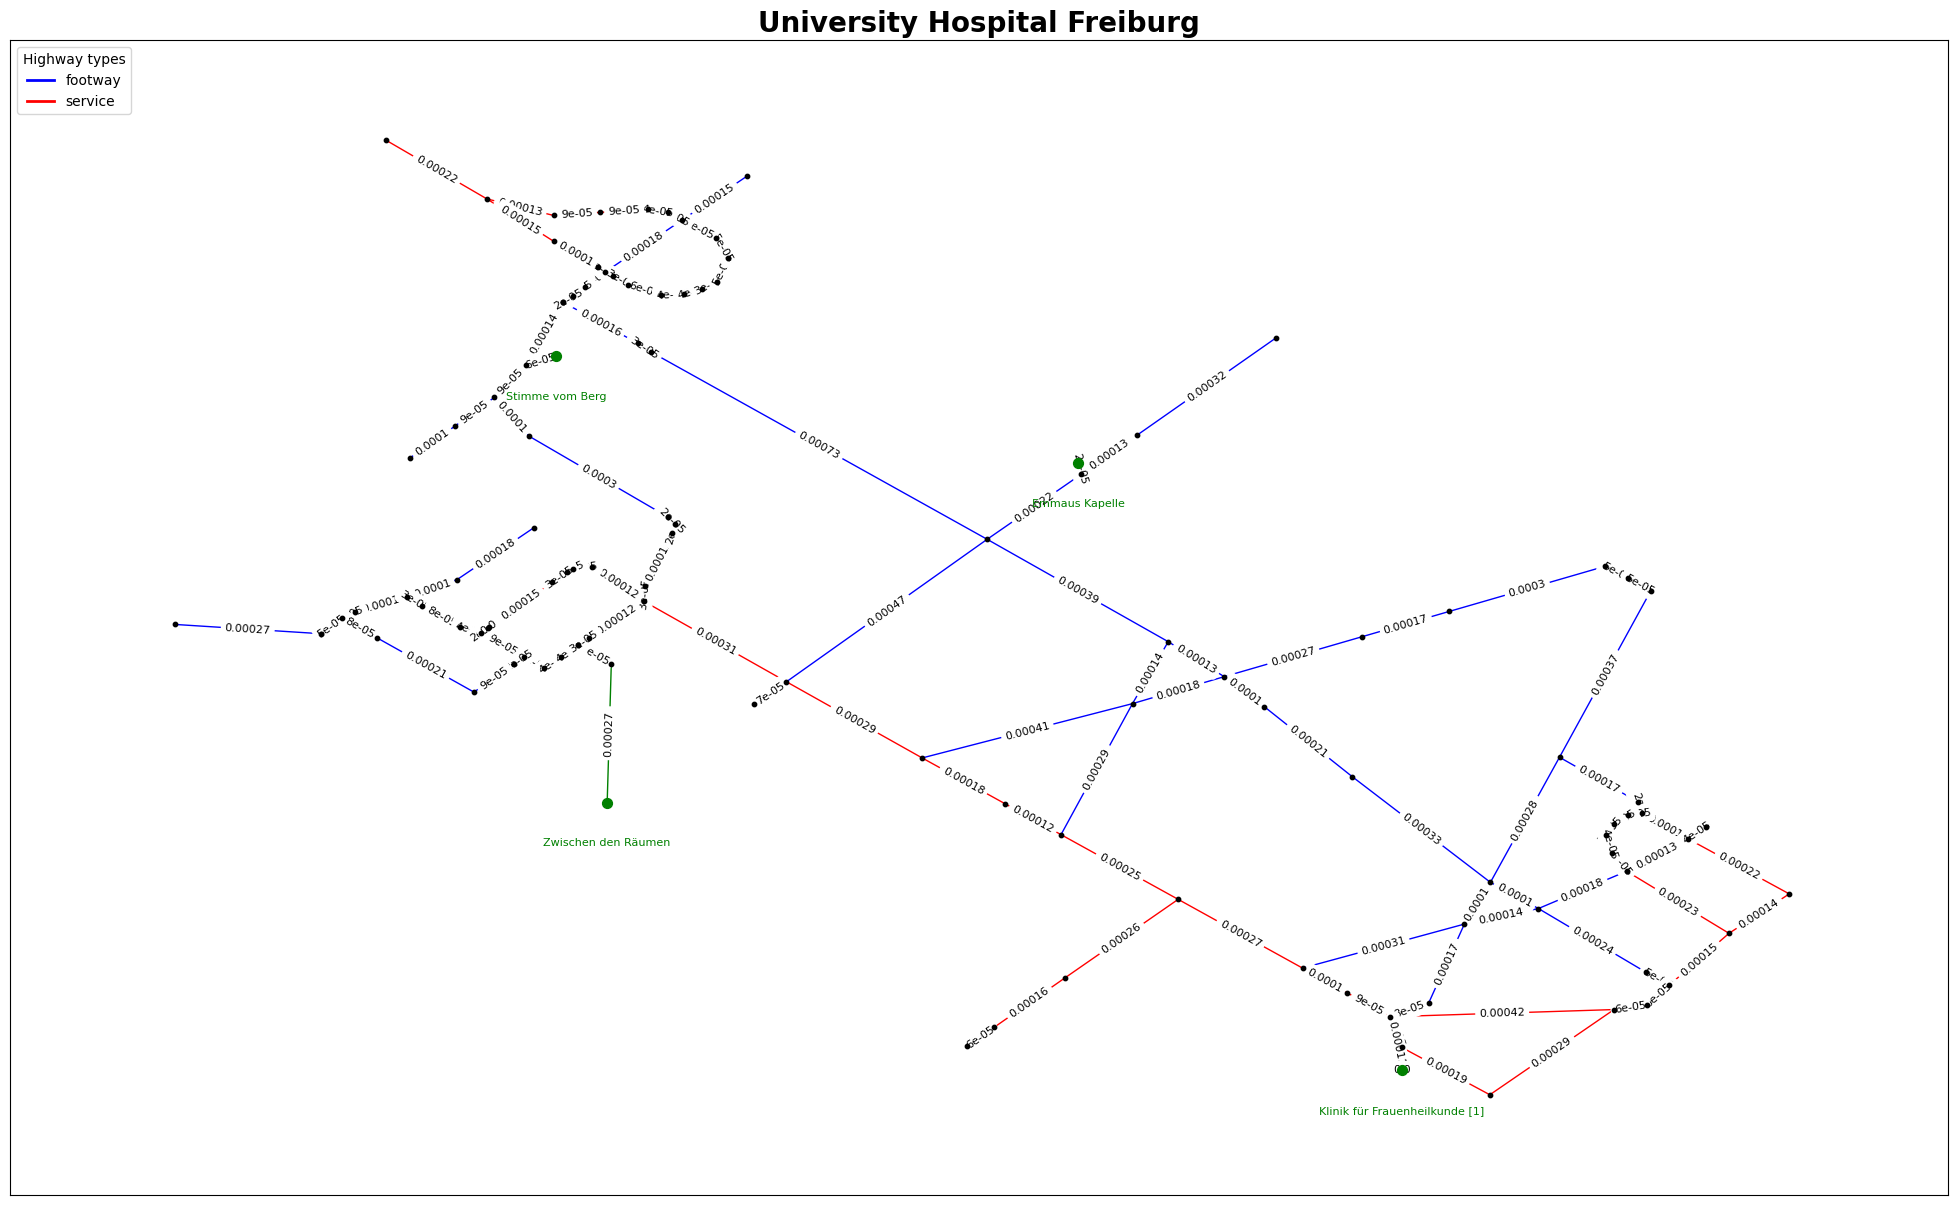

In [78]:
# define colors for the different highway types
colors = ['blue', 'red', 'yellow', 'orange', 'green', 'purple', 'pink', 'brown']

# plot the graph where all nodes are placed at their geographical position
pos = {key: (float(value[0]), float(value[1])) for key, value in nds.items()}
# correct position for the labels
pos_labels = {key: (float(value[0]), float(value[1]) - 0.00008) for key, value in nds.items()}
plt.figure(figsize=(25, 15))

# plot subgraph of the largest connected component
# plot only nodes that have a name
nx.draw_networkx_nodes(G_largest, pos, nodelist=[node for node in G_largest.nodes if nds[node][2] is not None and node in named_nodes],
                       node_color='green', node_size=50)
# label them
nx.draw_networkx_labels(G_largest, pos=pos_labels,
                        labels={node: nds[node][2] for node in G_largest.nodes if nds[node][2] is not None and node in named_nodes},
                        font_size=8, font_color='green')
# add all other nodes that are part of the largest connected component
nx.draw_networkx_nodes(G_largest, pos, nodelist=[node for node in G_largest.nodes if nds[node][2] is None],
                       node_color='black', node_size=10)
# add edges from the highways graph if they are part of the largest connected component
if params['highways'] is not None:
    for i, highway_type in enumerate(params['highways']):
        nx.draw_networkx_edges(G_largest, pos, edgelist=[edge for edge in G_highways.edges
                                                         if edge_labels_highways[edge] == highway_type
                                                         and edge[0] in G_largest.nodes and edge[1] in G_largest.nodes],
                            edge_color=colors[i], width=1)
# add edges from named nodes to the closest node on a way
nx.draw_networkx_edges(G_largest, pos, edgelist=[(node, closest_node[node]) for node in closest_node],
                       edge_color='green', width=1)
# label the edges with the weights
edge_labels = {(u, v): round(G_largest_weighted[u][v]['weight'], 5) for u, v in G_largest_weighted.edges()}
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)

# plot the graph
plt.title('University Hospital Freiburg', fontsize=20, fontweight='bold')
# legend that described colors and highway types
if params['highways'] is not None:
    plt.legend([plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(params['highways']))],
            params['highways'], fontsize=10, title='Highway types', loc='upper left')
plt.show()

# 9) Shortest Path

In [79]:
# define source and target node
source_node = 'Klinik für Frauenheilkunde [1]'
target_node = 'Stimme vom Berg'
# ['Zwischen den Räumen', 'Stimme vom Berg','Emmaus Kapelle', 'Klinik für Frauenheilkunde [1]', 'Ernst von Bergmann']

In [80]:
# find node id of source and target node
source_node_id = [node for node, name in named_nodes.items() if name == source_node][0]
target_node_id = [node for node, name in named_nodes.items() if name == target_node][0]

In [81]:
# use the a* algorithm to find the shortest path between the source and target node
path = nx.astar_path(G_largest_weighted, source_node_id, target_node_id,
                     heuristic=lambda u, v: ((float(nds[u][0]) - float(nds[v][0]))**2 + (float(nds[u][1]) - float(nds[v][1]))**2)**0.5)

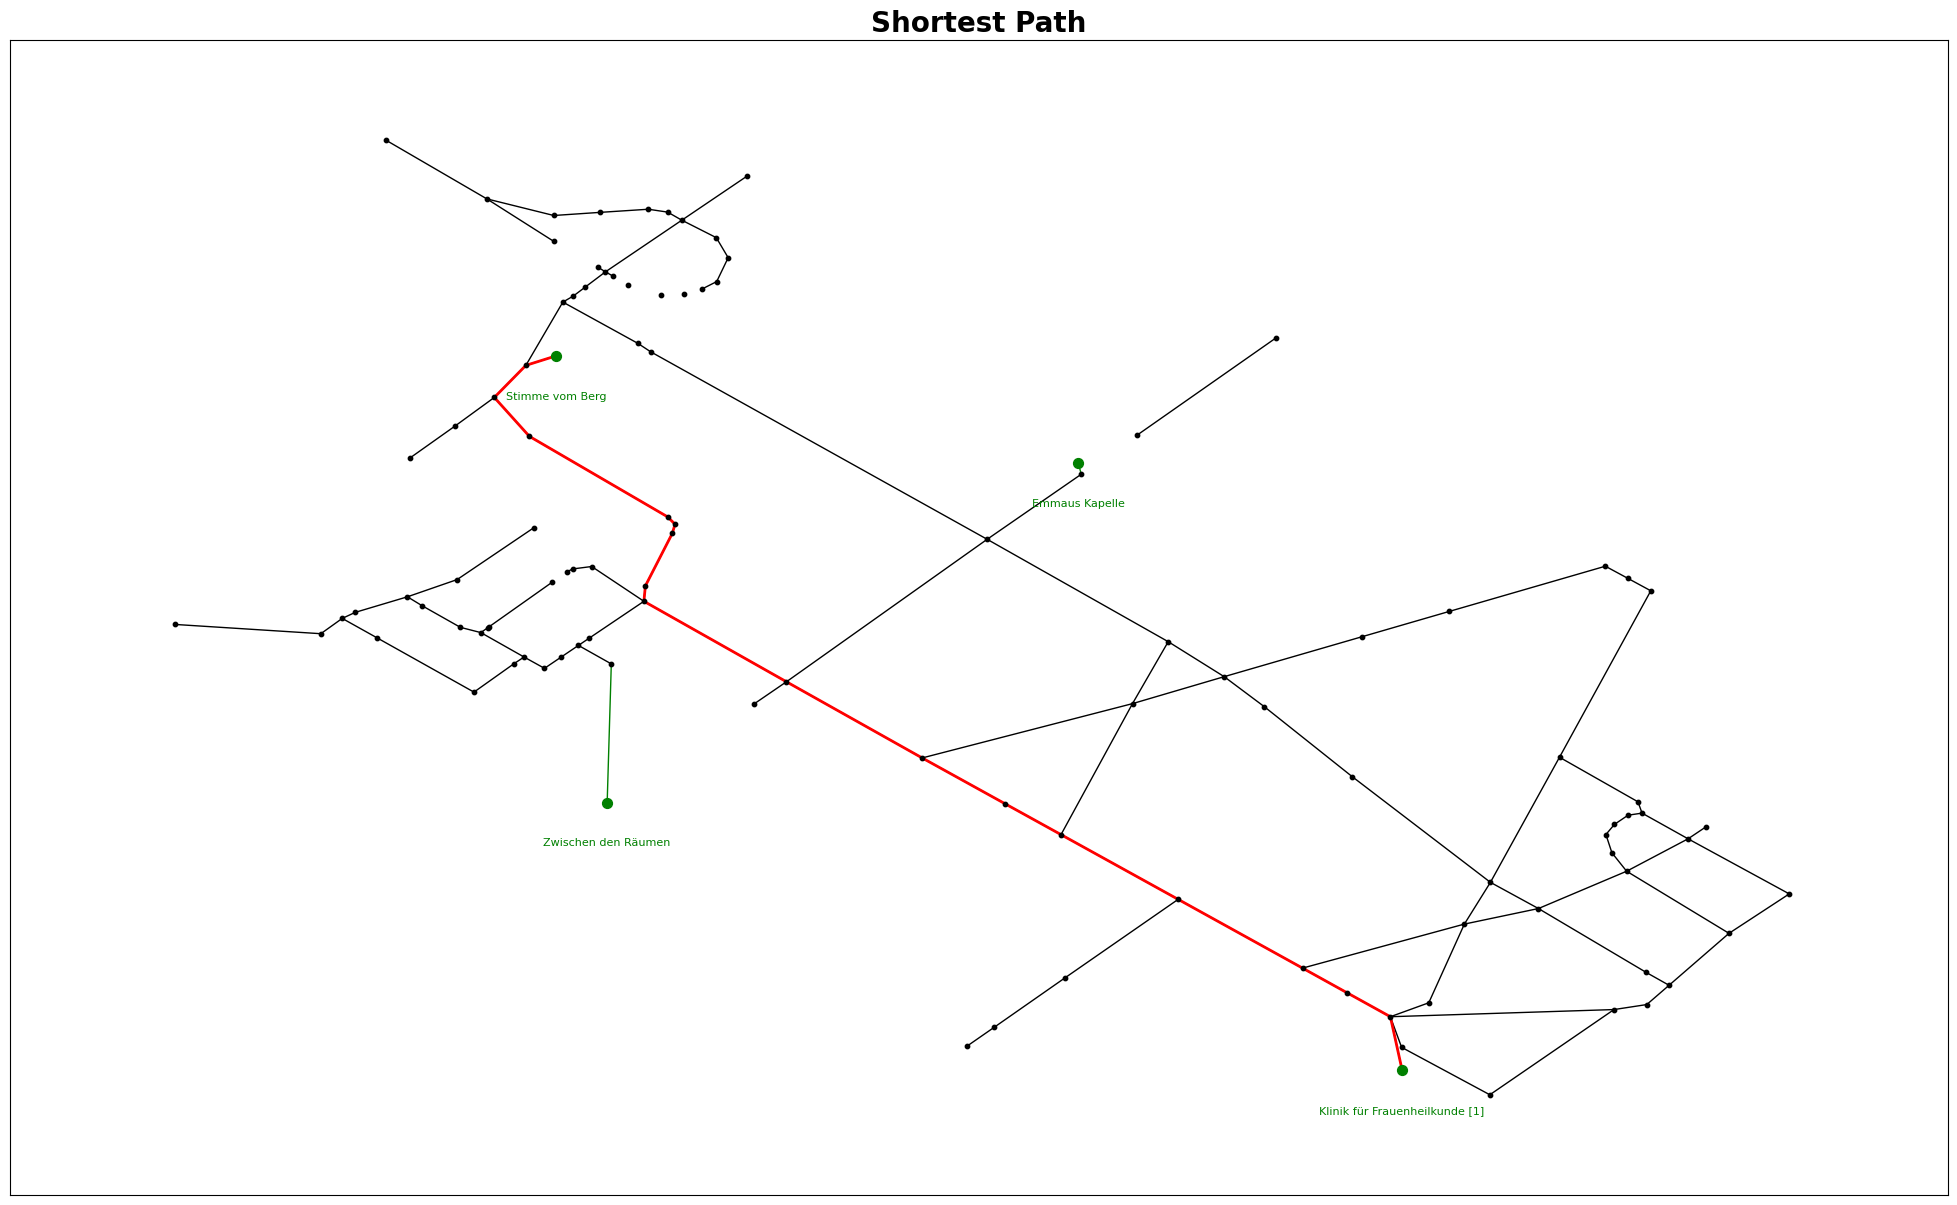

In [82]:
# plot the graph where all nodes are placed at their geographical position
pos = {key: (float(value[0]), float(value[1])) for key, value in nds.items()}
# correct position for the labels
pos_labels = {key: (float(value[0]), float(value[1]) - 0.00008) for key, value in nds.items()}
plt.figure(figsize=(25, 15))

# plot subgraph of the largest connected component
# plot only nodes that have a name
nx.draw_networkx_nodes(G_largest, pos, nodelist=[node for node in G_largest.nodes if nds[node][2] is not None and node in named_nodes],
                       node_color='green', node_size=50)
# label them
nx.draw_networkx_labels(G_largest, pos=pos_labels,
                        labels={node: nds[node][2] for node in G_largest.nodes if nds[node][2] is not None and node in named_nodes},
                        font_size=8, font_color='green')
# add all other nodes that are part of the largest connected component
nx.draw_networkx_nodes(G_largest, pos, nodelist=[node for node in G_largest.nodes if nds[node][2] is None],
                       node_color='black', node_size=10)
# add edges from the highways graph if they are part of the largest connected component
if params['highways'] is not None:
    for i, highway_type in enumerate(params['highways']):
        nx.draw_networkx_edges(G_largest, pos, edgelist=[edge for edge in G_highways.edges
                                                         if edge_labels_highways[edge] == highway_type
                                                         and edge[0] in G_largest.nodes and edge[1] in G_largest.nodes],
                            edge_color='black', width=1)
# add edges from named nodes to the closest node on a way
nx.draw_networkx_edges(G_largest, pos, edgelist=[(node, closest_node[node]) for node in closest_node],
                       edge_color='green', width=1)
# plot shortest path
nx.draw_networkx_edges(G_largest, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)],
                       edge_color='red', width=2)

# plot the graph
plt.title('Shortest Path', fontsize=20, fontweight='bold')
plt.show()

# 10) Dynamic Visualization

In [83]:
# for every edge in the shortest path, calculate the linear function that describes the edge
# and store the function in a dictionary
edge_functions = {}
for i in range(len(path)-1):
    # calculate the linear function that describes the edge
    m = (float(nds[path[i+1]][1]) - float(nds[path[i]][1])) / (float(nds[path[i+1]][0]) - float(nds[path[i]][0]))
    n = float(nds[path[i]][1]) - m * float(nds[path[i]][0])
    edge_functions[(path[i], path[i+1])] = (m, n)

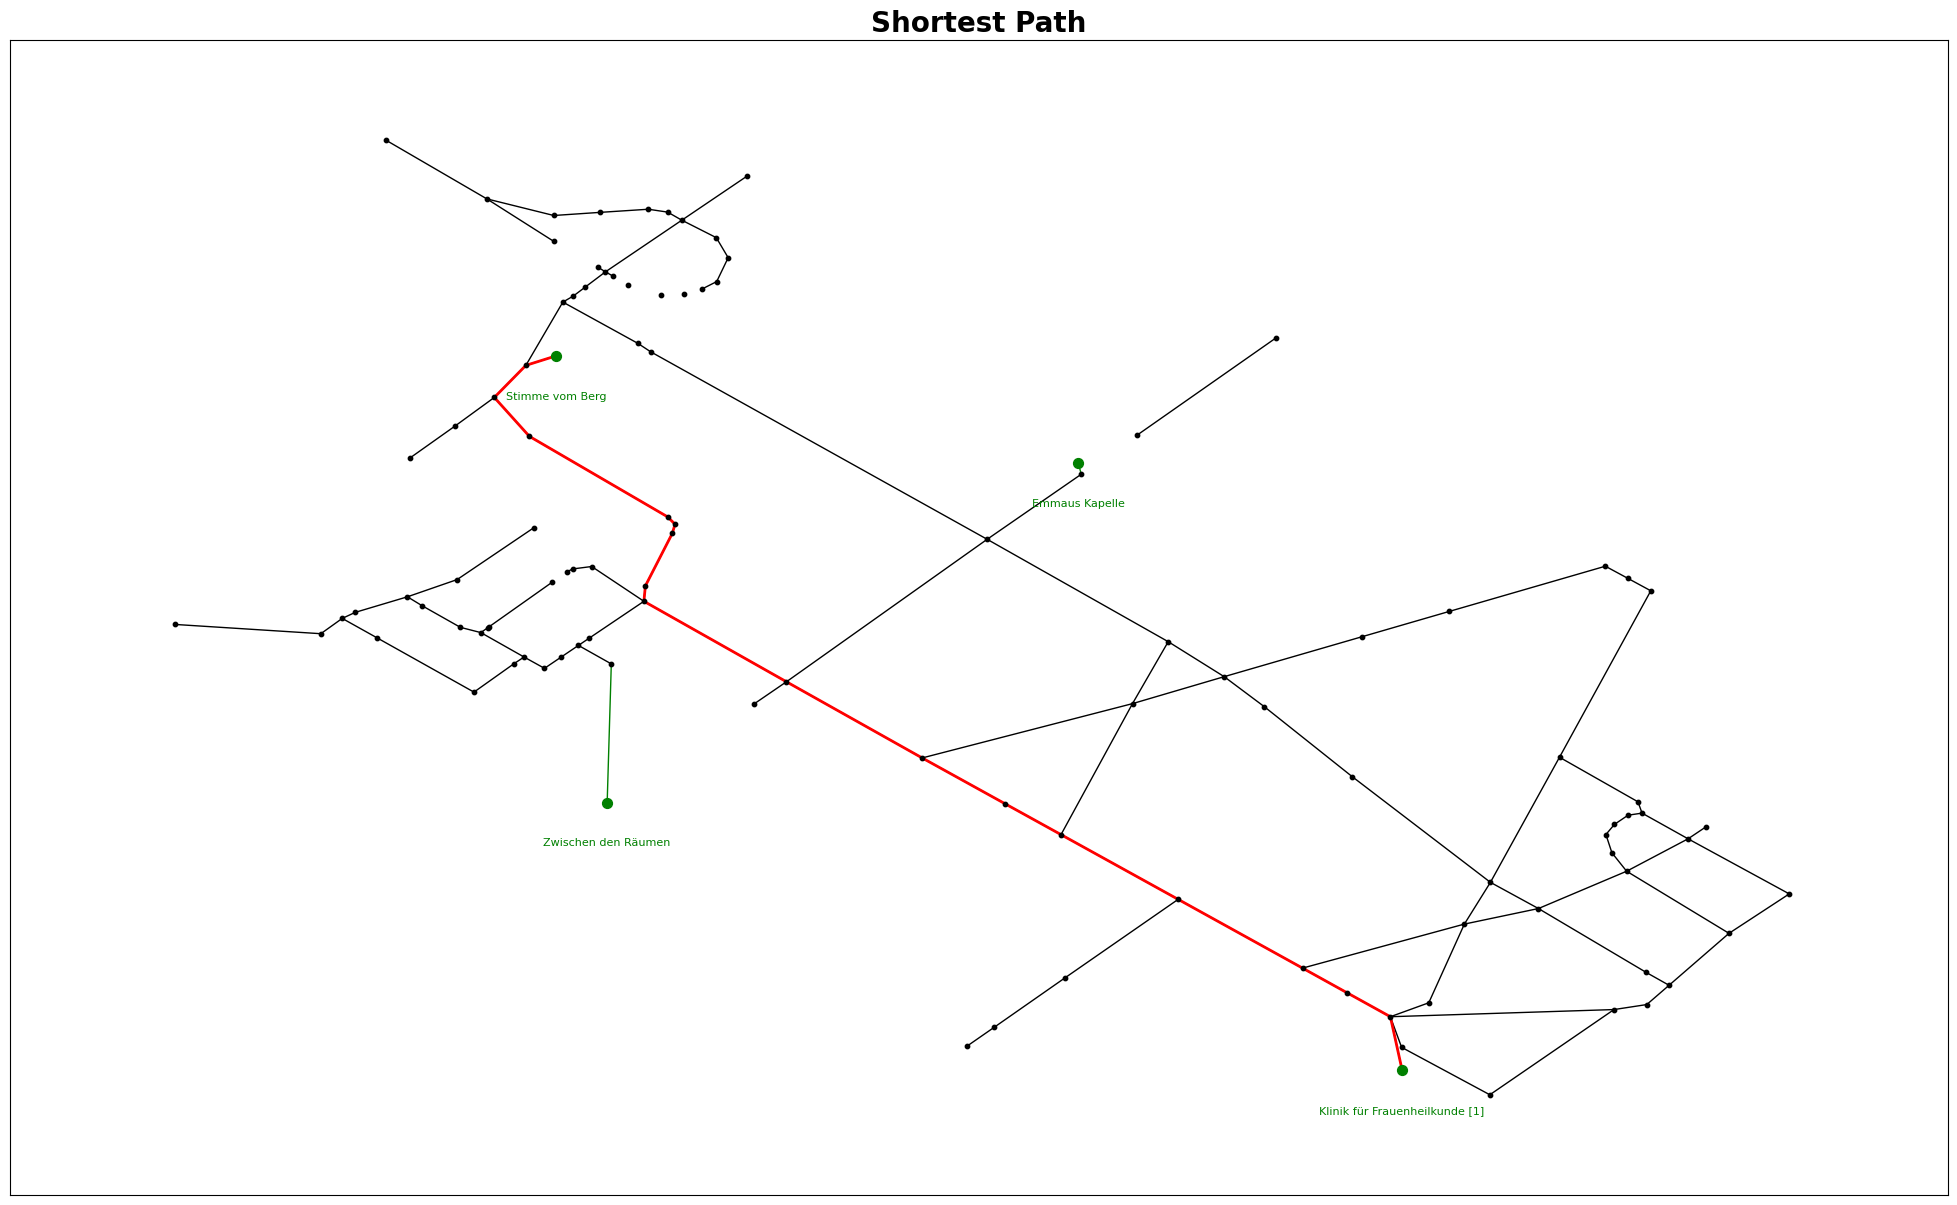

In [84]:
# plot the graph where all nodes are placed at their geographical position
pos = {key: (float(value[0]), float(value[1])) for key, value in nds.items()}
# correct position for the labels
pos_labels = {key: (float(value[0]), float(value[1]) - 0.00008) for key, value in nds.items()}
plt.figure(figsize=(25, 15))

# plot subgraph of the largest connected component
# plot only nodes that have a name
nx.draw_networkx_nodes(G_largest, pos, nodelist=[node for node in G_largest.nodes if nds[node][2] is not None and node in named_nodes],
                       node_color='green', node_size=50)
# label them
nx.draw_networkx_labels(G_largest, pos=pos_labels,
                        labels={node: nds[node][2] for node in G_largest.nodes if nds[node][2] is not None and node in named_nodes},
                        font_size=8, font_color='green')
# add all other nodes that are part of the largest connected component
nx.draw_networkx_nodes(G_largest, pos, nodelist=[node for node in G_largest.nodes if nds[node][2] is None],
                       node_color='black', node_size=10)
# add edges from the highways graph if they are part of the largest connected component
if params['highways'] is not None:
    for i, highway_type in enumerate(params['highways']):
        nx.draw_networkx_edges(G_largest, pos, edgelist=[edge for edge in G_highways.edges
                                                         if edge_labels_highways[edge] == highway_type
                                                         and edge[0] in G_largest.nodes and edge[1] in G_largest.nodes],
                            edge_color='black', width=1)
# add edges from named nodes to the closest node on a way
nx.draw_networkx_edges(G_largest, pos, edgelist=[(node, closest_node[node]) for node in closest_node],
                       edge_color='green', width=1)
# plot shortest path
nx.draw_networkx_edges(G_largest, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)],
                       edge_color='red', width=2)

# plot the graph
plt.title('Shortest Path', fontsize=20, fontweight='bold')
plt.show()

In [85]:
list(G.edges())
# save as csv-file
df = pd.DataFrame(list(G.edges()), columns=['node1', 'node2'])
df.to_csv('edges_UH_Graph.csv', index=False)

In [86]:
list(G.nodes())
# save as csv-file
df = pd.DataFrame(list(G.nodes()), columns=['node'])
df.to_csv('nodes_UH_Graph.csv', index=False)